In [3]:
# Einfaches 0-dimensionales globales Energiebilanzmodell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

def OLR(T, tau):
    """ Stefan-Boltzmann law """
    sigma = 5.67e-8
    return tau * sigma * T**4

def ASR(Q, alpha):
    """ Absorbed shortwave radiation """
    return (1-alpha) * Q


def step_forward(Q, T, Cw, alpha, tau, dt):
    return T + dt / Cw * ( ASR(Q, alpha) - OLR(T, tau) )


def ebm(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    ''' This is a simple Energy Balance Model with global radiation and outgoing longwave radiation.'''
  
    # Create result arrays
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Timestep
    dt = 60*60*24*365                  # convert days to seconds

    # Initial and boundary conditions
    Ts[0] = T0 

    # Calculation
    for n in range(years):
        Years[n+1] = n+1
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha, tau, dt )
        
        
    return Years, Ts

def plot_ebm(yrs, y, albedo, tau, plot=True, min=270, max=300, name='no name', title='No title'):
    # Erzeugen von Daten
    dates = yrs
    data = y  # Generierung von zufälligen Daten
    
    # Erstellen des Plotly Graph-Objekts
    fig = go.Figure()

    # Hinzufügen der Zeitreihe zum Graph
    fig.add_trace(go.Scatter(x=dates, y=data, mode='lines', name=name))
    
    # Hinzufügen von Titel und Achsenbeschriftungen
    fig.update_layout(title=title,
                  xaxis_title='Jahre',
                  yaxis_title='Emissionstemperatur [K]',
                  yaxis=dict(range=[min, max]),)

    # Zeige den Plot an
    if plot:

        fig.show()
    
        print('Albedo: {:.2f} [-]'.format(albedo))
        print('Transmissivität: {:.2f} [-]'.format(tau))
        print('Gleichgewichtstemperatur: {:.2f} K'.format(y[-1]))

    return fig

# Einfaches 0-dimensionales globales Energiebilanzmodell

In [4]:
def run_ebm(albedo=0.3,tau=0.61):
    yrs, y = ebm(273, Q=1360/4, Cw=10e8, alpha=albedo, tau=tau, years=200)
    plot_ebm(yrs, y, albedo, tau, plot=True, min=250, max=300, title='Gleichgewichtstemperature OLR=ASR')

interact(run_ebm, albedo=(0.1,0.9,0.01), tau=(0.55,0.70,0.001))


interactive(children=(FloatSlider(value=0.3, description='albedo', max=0.9, min=0.1, step=0.01), FloatSlider(v…

<function __main__.run_ebm(albedo=0.3, tau=0.61)>

# Nichtlinearität, Rückkopplungen und Vorhersagbarkeit

In [5]:
# Von-May-Gleichung

import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def von_may(y0,r):
    '''
    This function integrates the Von-May Equationn using a then initial condition y0, 
    and the parameter r
    
    y0 :: initial value
    r  :: pre-defined parameter
    
    '''

    # Assignments
    # The variable yi contains always y-value at timestep t. 
    # At the beginning, we assume that the old value 
    # corresponds to the intial value. 
    yi = y0  
    
    # The newly calculated y-values are stored in the result list. 
    # The first value in the list is the initial value for y
    result = [yi]

    # Integrate the Von-May equation over 500 time steps
    for t in range(500):
        # Here, we calculate the new y-values according to the Von-May-Gleichung
        y = r*yi*(1-yi)    
        
        # Store newly calculated values to yi (old value for the next iteration)
        yi = y   
        
        # Append the new y-value to the result list
        result.append(y)   

    # Return the result list
    return(result)

def plot_may(res):
    # Erzeugen von Daten
    dates = np.arange(len(res))
    data = res  # Generierung von zufälligen Daten
    
    # Erstellen des Plotly Graph-Objekts
    fig = go.Figure()
    
    # Hinzufügen der Zeitreihe zum Graph
    fig.add_trace(go.Scatter(x=dates, y=data, mode='lines', name='Random Data'))
    
    # Hinzufügen von Titel und Achsenbeschriftungen
    fig.update_layout(title='Von-May-Gleichung',
                      xaxis_title='Zeit',
                      yaxis_title='y',
                      yaxis=dict(range=[0.0, 1.0]),)
    
    # Zeige den Plot an
    fig.show()


def ensemble_may(n, y0, r):
    """
    n :: ensemble members
    y0 :: initial value
    r :: pre-defined parameter
    """
    # Create the result list
    result = []
    
    for ens_member in range(n):
        rnd = random.normalvariate(r, 0.015)
        result.append(von_may(y0, rnd))
        
    return result


def plot_ensemble(ens):

    # Berechne das ensemble mean
    ens_mean = np.mean(np.array(ens),axis=0)
    
    # Generieren von Daten
    data = ens_mean
    times = np.arange(len(ens_mean))  # Zeitachse von 1 bis 100
    
    # Erstellen eines Subplot-Layouts mit 1 Zeile und 2 Spalten
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Zeitreihe", "Verteilung"))
    
    # Hinzufügen der Zeitreihe zum ersten Subplot
    fig.add_trace(go.Scatter(x=times, y=data, mode='lines', name='Zeitreihe'), row=1, col=1)
    
    # Hinzufügen eines Histogramms der Daten zum zweiten Subplot
    fig.add_trace(go.Histogram(x=data, name='Verteilung'), row=1, col=2)
    
    # Aktualisierung des Layouts für eine bessere Darstellung
    fig.update_layout(title_text="Zeitreihe und Verteilung", showlegend=False)
    fig.update_xaxes(title_text="Zeit", row=1, col=1)
    fig.update_xaxes(title_text="Wert", row=1, col=2)
    fig.update_yaxes(title_text="Werte", row=1, col=1)
    fig.update_yaxes(title_text="Häufigkeit", row=1, col=2)
    
    fig.show()


**Experimente** Verschiedene r-Werte (zwischen 2.8 und 3.95) und Anfangsbedingungen für y

In [6]:
# Experimente 
def test(r=2.8):
    res = von_may(0.5, r)
    plot_may(res)

interact(test, r=(2.8,3.95))

interactive(children=(FloatSlider(value=2.8, description='r', max=3.95, min=2.8), Output()), _dom_classes=('wi…

<function __main__.test(r=2.8)>

In [7]:
# Von-May-Gleichung Ensemble
def run_ensemble(n=1):
    ens = ensemble_may(n, 0.5, 3.93)
    plot_ensemble(ens)

interact(run_ensemble, n=(1,200,1))

interactive(children=(IntSlider(value=1, description='n', max=200, min=1), Output()), _dom_classes=('widget-in…

<function __main__.run_ensemble(n=1)>

# Erweitertes 0-dimensionales globales Energiebilanzmodell

In [8]:
# Erweitertes 0-dimensionales globales Energiebilanzmodell
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import gaussian_kde


# Import some modules which are used in the function
import random         # Module to generate random number
import numpy as np    # Numpy

def OLR(T, tau):
    """ Stefan-Boltzmann law """
    sigma = 5.67e-8              # Stefan-Boltzmann constant
    return tau * sigma * T**4    # Return the OLR calculated by the Stefan-Boltzmann law

def ASR(Q, alpha):
    """ Absorbed shortwave radiation """
    return (1-alpha) * Q         # Return the ASR, with the albedo value alpha


def step_forward(Q, T, Cw, alpha, tau, dt):
    # Return the updated T-value (time-dependent EBM)    
    return T + dt / Cw * ( ASR(Q, alpha) - OLR(T, tau) ) 

def ebm_stochastic(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.61, years=100):
    ''' This is a simple Energy Balance Model with a random tranmissivity.'''
  
    # Create result arrays (numpy) filled with zeros
    # Ts stores the temperature values, years the years since the beginning of
    # the simulation
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Timestep in seconds (time step is 1 year)
    dt = 60*60*24*365                  # convert days to seconds

    # Initial and boundary conditions
    # Set the first value in the Ts to the initial condition
    Ts[0] = T0 

    # Integration over all years
    for n in range(years):
        # Generate a random tau value with mean value tau and standard-deviation
        # of 10 % its value
        tau_rnd = random.normalvariate(tau,tau*0.1)
        # Store the number of iterations in the Years array
        Years[n+1] = n+1
        # Store the new temperature value in Ts
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha, tau_rnd, dt )
        
    # Return both the temperature and year array
    return Years, Ts

def ebm_ice_albedo(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.61, years=100):
    ''' This is a simple Energy Balance Model including ice-albedo feedback.'''
  
    # Create result arrays (numpy) filled with zeros
    # Ts stores the temperature values, years the years since the beginning of
    # the simulation
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Timestep in seconds (time step is 1 year)
    dt = 60*60*24*365                  # convert days to seconds

    # Initial and boundary conditions
    # Set the first value in the Ts to the initial condition
    Ts[0] = T0 

    # Integration over all years
    for n in range(years):
        # Parametrization of albedo. The albedo is a function of temperature.
        alpha_adapt = alpha * (1 - 0.2 * np.tanh(0.5*(Ts[n]-288)))
        # Store the number of iterations in the Years array
        Years[n+1] = n+1
        # Store the new temperature value in Ts
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha_adapt, tau, dt )
        
    # Return both the temperature and year array
    return Years, Ts

def ebm_ice_albedo_stochastic(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.61, years=100):
    ''' This is a simple Energy Balance Model including ice-albedo feedback.'''
  
    # Create result arrays (numpy) filled with zeros
    # Ts stores the temperature values, years the years since the beginning of
    # the simulation
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Timestep in seconds (time step is 1 year)
    dt = 60*60*24*365                  # convert days to seconds

    # Initial and boundary conditions
    # Set the first value in the Ts to the initial condition
    Ts[0] = T0 

    # Integration over all years
    for n in range(years):
        # Parametrization of albedo. The albedo is a function of temperature.
        alpha_adapt = alpha * (1 - 0.2 * np.tanh(0.5*(Ts[n]-288)))

        # Sample the transmissivity from a normal distribution with a standard deviation of 10%
        tau_rnd = random.normalvariate(tau, tau*0.07) 

        # Store the number of iterations in the Years array
        Years[n+1] = n+1
        # Store the new temperature value in Ts
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha_adapt, tau_rnd, dt )
        
    # Return both the temperature and year array
    return Years, Ts

def plot_line_hist(T):

    # Generieren von Daten
    data = T
    times = np.arange(len(T))  # Zeitachse von 1 bis 100
    
    # Erstellen eines Subplot-Layouts mit 1 Zeile und 2 Spalten
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Zeitreihe", "Verteilung"))
    
    # Hinzufügen der Zeitreihe zum ersten Subplot
    fig.add_trace(go.Scatter(x=times, y=data, mode='lines', name='Zeitreihe'), row=1, col=1)
    
    # Hinzufügen eines Histogramms der Daten zum zweiten Subplot
    fig.add_trace(go.Histogram(x=data, name='Verteilung'), row=1, col=2)
    
    # Aktualisierung des Layouts für eine bessere Darstellung
    fig.update_layout(title_text="Zeitreihe und Verteilung", showlegend=False)
    fig.update_xaxes(title_text="Zeit", row=1, col=1)
    fig.update_xaxes(title_text="Wert", row=1, col=2)
    fig.update_yaxes(title_text="Werte", row=1, col=1)
    fig.update_yaxes(title_text="Häufigkeit", row=1, col=2)
    
    fig.show()


def plot_attractor(Ts):
    
    # Generieren von Daten
    x = Ts[0:-1]
    y = Ts[1:]
    times = np.arange(len(Ts)-1)  # Zeitachse von 1 bis 100

    # Berechnen der Dichte der Datenpunkte
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    # Erstellen des Plotly Scatter Plots mit Dichte-farbcodierten Punkten
    fig = go.Figure(data=go.Scatter(x=x, y=y, mode='markers',
                                     marker=dict(size=5, color=z, colorscale='Viridis', showscale=True)))
    
    # Layout-Updates
    fig.update_layout(title='Attraktoren im Klimasystem',
                      xaxis_title='X-Achse',
                      yaxis_title='Y-Achse',
                      xaxis=dict(scaleanchor="y", scaleratio=1, range=[265, 310]),
                      yaxis=dict(constrain='domain',range=[265, 310]),
                         width=800,  # Breite der Figur in Pixel
        height=800)  # Höhe der Figur in Pixel)
    
    # Plot anzeigen
    fig.show()

Einfaches EBM mit randomisierter Transmissivität

In [9]:
# Wir integrieren das stochastische EBM für 500 Jahre

albedo = 0.3
tau    = 0.61

def run_ebm(albedo=0.3,tau=0.61):
    yrs, y = ebm(273, Q=1360/4, Cw=10e8, alpha=albedo, tau=tau, years=200)
    plot_ebm(yrs, y, albedo, tau, plot=True, min=250, max=300, title='Gleichgewichtstemperature OLR=ASR')

def run_stochastic(albedo=0.3,tau=0.61):
    yrs, y = yrs, Ts = ebm_stochastic(273, Q=1360/4, Cw=10e8, alpha=albedo, tau=tau, years=500)
    plot_ebm(yrs, y, albedo, tau, plot=True, min=250, max=300, title='Gleichgewichtstemperature OLR=ASR')


interact(run_ebm, albedo=(0.1,0.9,0.01), tau=(0.55,0.70,0.001))
interact(run_stochastic, albedo=(0.1,0.9,0.01), tau=(0.55,0.70,0.001))

#yrs, y = ebm(273, Q=1360/4, Cw=10e8, alpha=albedo, tau=tau, years=200)
#yrs, Ts = ebm_stochastic(273, Q=1360/4, Cw=10e8, alpha=albedo, tau=tau, years=500)

# Plot the results
#plot_ebm(yrs, y, albedo, tau, plot=True, title='Gleichgewichtstemperature OLR=ASR')
#plot_ebm(yrs, Ts, albedo, tau, plot=False, title='Gleichgewichtstemperature OLR=ASR mit randomisierter Transmissivität')

interactive(children=(FloatSlider(value=0.3, description='albedo', max=0.9, min=0.1, step=0.01), FloatSlider(v…

interactive(children=(FloatSlider(value=0.3, description='albedo', max=0.9, min=0.1, step=0.01), FloatSlider(v…

<function __main__.run_stochastic(albedo=0.3, tau=0.61)>

Einfaches EMB mit Albedo Parametrisierung

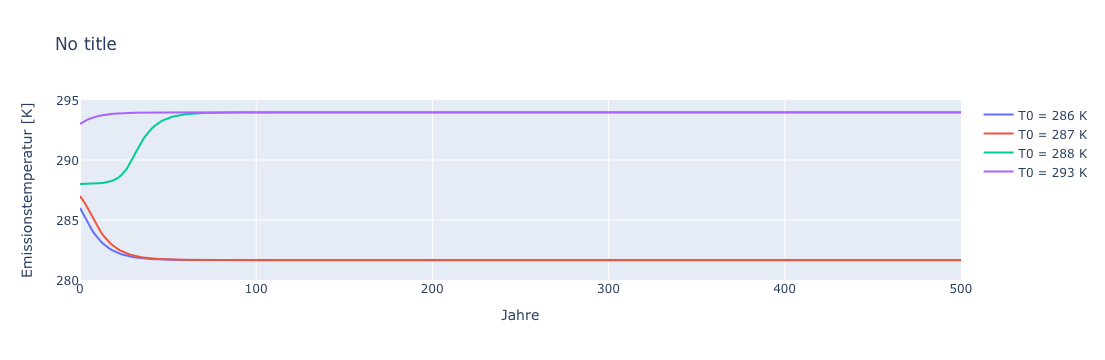

In [10]:
# Wir integrieren das EBM mit Albedo Parametrisierung für 500 Jahre

albedo = 0.3
tau    = 0.61
yrs, Ts286 = ebm_ice_albedo(286, Q=1360/4, Cw=10e8, alpha=albedo, tau=tau, years=500)
yrs, Ts287 = ebm_ice_albedo(287, Q=1360/4, Cw=10e8, alpha=albedo, tau=tau, years=500)
yrs, Ts288 = ebm_ice_albedo(288, Q=1360/4, Cw=10e8, alpha=albedo, tau=tau, years=500)
yrs, Ts293 = ebm_ice_albedo(293, Q=1360/4, Cw=10e8, alpha=albedo, tau=tau, years=500)

# Plot the results
f = plot_ebm(yrs, Ts286, albedo, tau, plot=False, min=280, max=295, name='T0 = 286 K')
f.add_trace(go.Scatter(x=yrs, y=Ts287, mode='lines', name='T0 = 287 K'))
f.add_trace(go.Scatter(x=yrs, y=Ts288, mode='lines', name='T0 = 288 K'))
f.add_trace(go.Scatter(x=yrs, y=Ts293, mode='lines', name='T0 = 293 K'))


EBM mit randomisierter Transmissivität und Albedo Parametrisierung

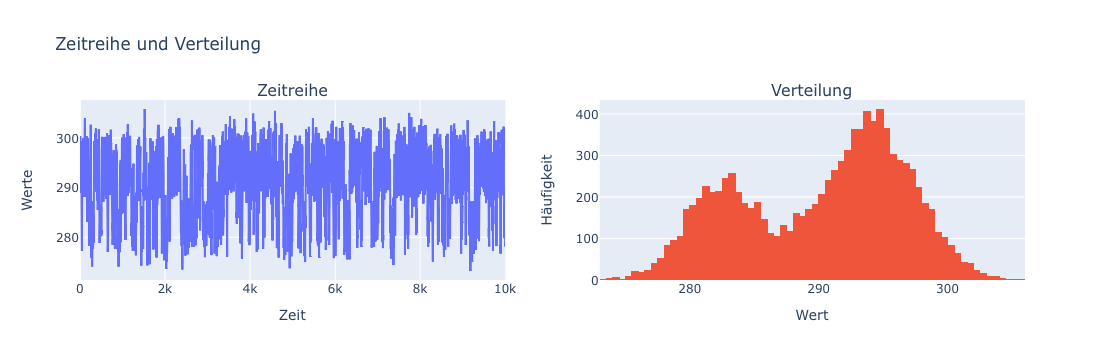

In [11]:
# Run the simulations and plot the results
yrs, Ts = ebm_ice_albedo_stochastic(289, Q=342, Cw=2*10**8, \
                                                     alpha=0.30, tau=0.608, years=10000)

# Plot the results
plot_line_hist(Ts)

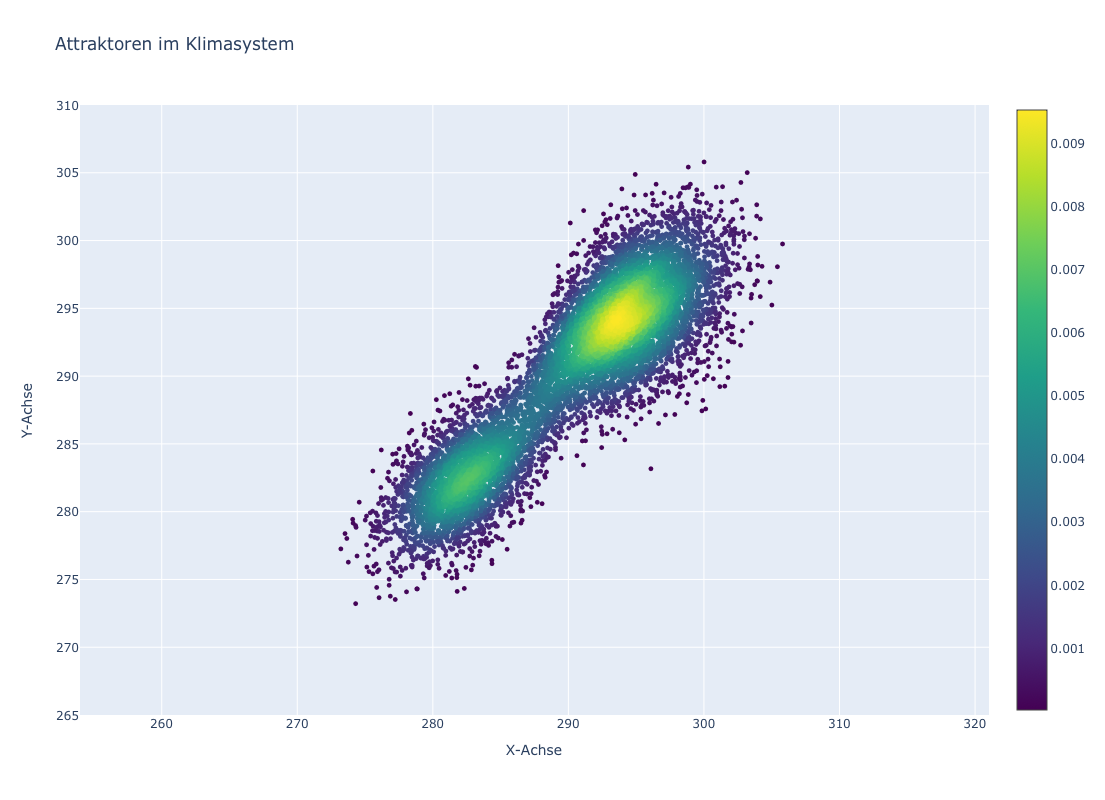

In [12]:
plot_attractor(Ts)